In [2]:
import warnings
import time
import os

# RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
#     CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
#     GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
#     AWS_NO_SIGN_REQUEST="YES",
#     GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
#     GDAL_SWATH_SIZE="200000000",
#     VSI_CURL_CACHE_SIZE="200000000",
# )
# os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
# from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry
import geopandas as gpd
import dask_geopandas
# from dask.distributed import Client
# from dask_gateway import GatewayCluster

import pystac_client
import planetary_computer as pc
from dask.distributed import Client, progress
import rioxarray

import sys
import os
current_folder = os.getcwd()
sys.path.insert(0, current_folder+'/raster')
sys.path.insert(0, current_folder+'/models')


In [3]:
def create_centroids_gdf(gdf):
    #Convert to equal area projection and back to avoid CRS issues with calculating centroid:
    c = kde_gdf.to_crs('+proj=cea').centroid.to_crs(gdf.crs)

    centroids = pd.DataFrame()
    centroids['grid_id'] = gdf.grid_id
    centroids['lon'] = c.x.values
    centroids['lat'] = c.y.values
    centroids = gpd.GeoDataFrame(centroids, geometry=gpd.points_from_xy(centroids['lon'], centroids['lat']))
    
    return centroids

def _query(points):
    """
    Find a STAC item for points in the `points` DataFrame

    Parameters
    ----------
    points : geopandas.GeoDataFrame
        A GeoDataFrame

    Returns
    -------
    geopandas.GeoDataFrame
        A new geopandas.GeoDataFrame with a `stac_item` column containing the STAC
        item that covers each point.
    """
    intersects = shapely.geometry.mapping(points.unary_union.convex_hull) #TODO replace with rectangular geometry

    search_start = "2019-01-01"
    search_end = "2019-12-31"
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                        modifier=pc.sign_inplace)
    # catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    # The time frame in which we search for non-cloudy imagery
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=intersects,
        datetime=[search_start, search_end],
        query={"eo:cloud_cover": {"lt": 10}},
        limit=500,
    )
    ic = search.get_all_items_as_dict()

    features = ic["features"]
    features_d = {item["id"]: item for item in features}

    data = {
        "eo:cloud_cover": [],
        "geometry": [],
    }

    index = []

    for item in features:
        data["eo:cloud_cover"].append(item["properties"]["eo:cloud_cover"])
        data["geometry"].append(shapely.geometry.shape(item["geometry"]))
        index.append(item["id"])

    items = gpd.GeoDataFrame(data, index=index, geometry="geometry").sort_values(
        "eo:cloud_cover"
    )
    point_list = points.geometry.tolist()

    point_items = []
    for point in point_list:
        covered_by = items[items.covers(point)]
        if len(covered_by):
            point_items.append(features_d[covered_by.index[0]])
        else:
            # There weren't any scenes matching our conditions for this point (too cloudy)
            point_items.append(None)

    return points.assign(stac_item=point_items)


dask_geopandas_partitions = 250

def add_sentinel_urls(centroids):
    
    print("Organizing grid centroids according to Hilbert distance...")

    ddf = dask_geopandas.from_geopandas(centroids, npartitions=1)
    hd = ddf.hilbert_distance().compute()
    centroids["hd"] = hd
    centroids = centroids.sort_values("hd")
    dgdf = dask_geopandas.from_geopandas(centroids, npartitions=dask_geopandas_partitions, sort=False)

    from dask_gateway import GatewayCluster
    
    try:
        print("Attemping to create a new dask client")
        cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.
        client = cluster.get_client()
        cluster.adapt(minimum=4, maximum=113)

        print(cluster.dashboard_link)
        print(client)

        meta = dgdf._meta.assign(stac_item=[])
        df2 = dgdf.map_partitions(_query, meta=meta).compute()

        
        data = df2.dropna(subset=["stac_item"])
        #Save it as a tuple -> (RGB,NIR)
        data['urls'] = [(item["assets"]["visual"]["href"], item["assets"]["B08"]["href"]) for item in data.stac_item.tolist()]
        data['crs']  = [item["properties"]["proj:epsg"] for item in data.stac_item.tolist()]
        print(data.stac_item[0]["properties"]["proj:epsg"])
        print("{} URLs acquired. Shutting Down Cluster".format(len(data)))
        cluster.close()
        
        data = data.drop(['hd','stac_item'], axis=1).set_index('grid_id').reset_index(drop=True)
        return data
    
    except Exception as e:
        print("Error thrown: ",e)
        cluster.close()
        return None
    

# Read Observations

## KDE

In [4]:
BUCKET_NAME = 'datasets-sdm'
folder = 'kde/ca'
filename = 'geolifeclef_ca_0.05deg_kde_0.5deg_epanechnikov.pkl'

s3_read_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, filename)
print(s3_read_path)

s3://datasets-sdm/kde/ca/geolifeclef_ca_0.05deg_kde_0.5deg_epanechnikov.pkl


In [5]:
kde_gdf = pd.read_pickle(s3_read_path)
kde_gdf.head()

,geometry,grid_id,prob_4911,prob_4912,prob_4922,prob_4923,prob_2329,prob_4927,prob_4930,prob_4382,...,prob_14228,prob_202,prob_9006,prob_272,prob_16726,prob_17029,prob_8230,prob_13366,prob_16533,prob_1455
0,"POLYGON ((-124.36556 40.23088, -124.36556 40.2...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"POLYGON ((-124.36556 40.28088, -124.36556 40.3...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"POLYGON ((-124.36556 40.33088, -124.36556 40.3...",2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"POLYGON ((-124.36556 40.38088, -124.36556 40.4...",3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"POLYGON ((-124.36556 40.43088, -124.36556 40.4...",4,0,0,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
num_classes = len(kde_gdf.columns) - 2
kde_gdf_classes = kde_gdf.columns.to_list()[2:]
len(kde_gdf_classes)

5079

## Val observations

In [30]:
filename = 'ca_val_obs.pkl'
s3_read_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, filename)
print(s3_read_path)

s3://datasets-sdm/kde/ca/ca_val_obs.pkl


In [31]:
ca_val_gdf = pd.read_pickle(s3_read_path)
ca_val_gdf.head()

,observation_id,latitude,longitude,species_id,geometry,prob_4911,prob_4912,prob_4922,prob_4923,prob_2329,...,prob_14228,prob_202,prob_9006,prob_272,prob_16726,prob_17029,prob_8230,prob_13366,prob_16533,prob_1455
0,20000282,41.523970,-124.045616,2560,POINT (-124.04562 41.52397),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20001056,38.354510,-122.514270,5205,POINT (-122.51427 38.35451),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20001135,38.807053,-122.369255,5243,POINT (-122.36925 38.80705),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20002394,34.023647,-118.417330,5544,POINT (-118.41733 34.02365),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20003318,35.178210,-120.745760,5109,POINT (-120.74576 35.17821),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Centroids

## Generate a list of centroids for every grid_id

In [26]:
centroids = create_centroids_gdf(kde_gdf)
centroids.head()

,grid_id,lon,lat,geometry
0,0,-124.390558,40.255879,POINT (-124.39056 40.25588)
1,1,-124.390558,40.305879,POINT (-124.39056 40.30588)
2,2,-124.390558,40.355879,POINT (-124.39056 40.35588)
3,3,-124.390558,40.405879,POINT (-124.39056 40.40588)
4,4,-124.390558,40.455879,POINT (-124.39056 40.45588)


## Fetch their URLs for Sentinel-2

In [27]:
%%time
centroids = add_sentinel_urls(centroids)


Organizing grid centroids according to Hilbert distance...
Attemping to create a new dask client
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.4893bcacce13496ea6950910b22ad859/status
<Client: 'tls://10.244.159.72:8786' processes=0 threads=0, memory=0 B>
32610
17173 URLs acquired. Shutting Down Cluster
CPU times: user 991 ms, sys: 110 ms, total: 1.1 s
Wall time: 1min 3s


In [29]:
centroids

,lon,lat,geometry,urls,crs
0,-119.590558,33.25588,POINT (-119.59056 33.25588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
1,-119.490558,33.20588,POINT (-119.49056 33.20588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
2,-119.440558,33.20588,POINT (-119.44056 33.20588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
3,-119.440558,33.25588,POINT (-119.44056 33.25588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
4,-119.490558,33.25588,POINT (-119.49056 33.25588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
...,...,...,...,...,...
17168,-114.590558,32.80588,POINT (-114.59056 32.80588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
17169,-114.540558,32.80588,POINT (-114.54056 32.80588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
17170,-114.540558,32.85588,POINT (-114.54056 32.85588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
17171,-114.490558,32.85588,POINT (-114.49056 32.85588),(https://sentinel2l2a01.blob.core.windows.net/...,32611


In [146]:
centroids.urls[17000]

('https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/11/S/PS/2019/11/17/S2A_MSIL2A_20191117T182641_N0212_R127_T11SPS_20201003T172221.SAFE/GRANULE/L2A_T11SPS_A023004_20191117T183204/IMG_DATA/R10m/T11SPS_20191117T182641_TCI_10m.tif?st=2022-12-07T01%3A43%3A31Z&se=2022-12-08T09%3A43%3A31Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-07T22%3A05%3A30Z&ske=2022-12-14T22%3A05%3A30Z&sks=b&skv=2021-06-08&sig=8je/7XBFUD7Yl1vjrzDVBmnQiSFnEQwCq3WcenvSwUc%3D',
 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/11/S/PS/2019/11/17/S2A_MSIL2A_20191117T182641_N0212_R127_T11SPS_20201003T172221.SAFE/GRANULE/L2A_T11SPS_A023004_20191117T183204/IMG_DATA/R10m/T11SPS_20191117T182641_B08_10m.tif?st=2022-12-07T01%3A43%3A31Z&se=2022-12-08T09%3A43%3A31Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-07T22%3A05%3A30Z&ske=2022-12-14T22%3A05%3A30Z&sk

# Dataset

In [10]:
%load_ext autoreload

In [30]:
BUCKET_NAME = 'datasets-sdm'
folder = 'geoLifeCLEF/rasters'
s3_raster_path = 's3://{}/{}/'.format(BUCKET_NAME, folder)
print(s3_raster_path)

s3://datasets-sdm/geoLifeCLEF/rasters/


In [155]:
%autoreload 2
from dataset import Dataset


In [49]:
SIDE_PX = 64

In [124]:
from torchvision import transforms
# target_transform = transforms.Compose([
#     transforms.ToTensor(),
#     # scales pixel values to range [-1, 1]
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),                                      
# ])

si_transform = transforms.Compose([
    # transforms.ToTensor(),
    # scales pixel values to range [-1, 1]
    transforms.Normalize(0.5, 0.5),                                      
])

In [183]:
train_set = Dataset(raster_root=s3_raster_path, subset="train", centroids=centroids, observations=kde_gdf, side_len_m=50000,side_px=SIDE_PX)

Setting up SI Patch Extractor..
Setting up env raster extractor..
Processing Raster file for  bio_1
Processing Raster file for  bio_2
Processing Raster file for  bio_3
Processing Raster file for  bio_4
Processing Raster file for  bio_5
Processing Raster file for  bio_6
Processing Raster file for  bio_7
Processing Raster file for  bio_8
Processing Raster file for  bio_9
Processing Raster file for  bio_10
Processing Raster file for  bio_11
Processing Raster file for  bio_12
Processing Raster file for  bio_13
Processing Raster file for  bio_14
Processing Raster file for  bio_15
Processing Raster file for  bio_16
Processing Raster file for  bio_17
Processing Raster file for  bio_18
Processing Raster file for  bio_19
Processing Raster file for  bdticm
Processing Raster file for  bldfie
Processing Raster file for  cecsol
Processing Raster file for  clyppt
Processing Raster file for  orcdrc
Processing Raster file for  phihox
Processing Raster file for  sltppt
Processing Raster file for  sndpp

In [184]:
%%time
# (patch, target) = train_set[2708]
(patch, target) = train_set[17000]

Extracting SI patches...
RGB max =  254
NIR max =  4699
torch.Size([3, 64, 64]) torch.Size([1, 64, 64])
Extracting env patches...
bio_1 tensor(2.1314, dtype=torch.float64) tensor(1.6443, dtype=torch.float64)
bio_2 tensor(1.6844, dtype=torch.float64) tensor(0.2762, dtype=torch.float64)
bio_3 tensor(0.9563, dtype=torch.float64) tensor(0.5136, dtype=torch.float64)
bio_4 tensor(-0.1874, dtype=torch.float64) tensor(-0.5200, dtype=torch.float64)
bio_5 tensor(3.0680, dtype=torch.float64) tensor(2.1821, dtype=torch.float64)
bio_6 tensor(1.7419, dtype=torch.float64) tensor(1.3643, dtype=torch.float64)
bio_7 tensor(0.1769, dtype=torch.float64) tensor(-0.5960, dtype=torch.float64)
bio_8 tensor(2.1710, dtype=torch.float64) tensor(-0.4464, dtype=torch.float64)
bio_9 tensor(1.8309, dtype=torch.float64) tensor(1.5286, dtype=torch.float64)
bio_10 tensor(2.7347, dtype=torch.float64) tensor(2.0032, dtype=torch.float64)
bio_11 tensor(1.7472, dtype=torch.float64) tensor(1.4319, dtype=torch.float64)
bio_12

In [185]:
patch[4:,:,:].max(), patch[4:,:,:].min(), patch[0:3,:,:].max(), patch[0:3,:,:].min(), patch[3,:,:].max(), patch[3,:,:].min()

(tensor(6.9752, dtype=torch.float64),
 tensor(-2.4819, dtype=torch.float64),
 tensor(0.9961, dtype=torch.float64),
 tensor(0.1882, dtype=torch.float64),
 tensor(0.4699, dtype=torch.float64),
 tensor(0.1263, dtype=torch.float64))

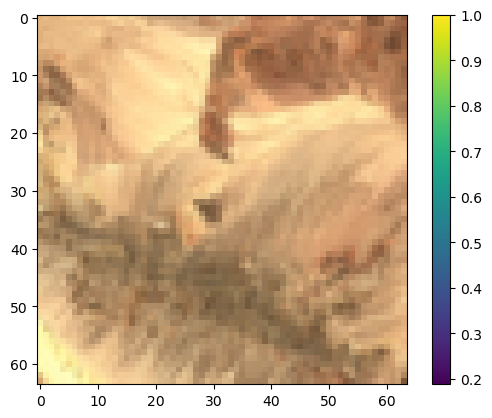

In [190]:
img = patch[0:3,:,:]
img = img.numpy()
img = img.transpose([1, 2, 0])
plt.imshow(img, vmax=1)
plt.colorbar()
plt.show()

(tensor(0.4699, dtype=torch.float64), tensor(0.4699, dtype=torch.float64))

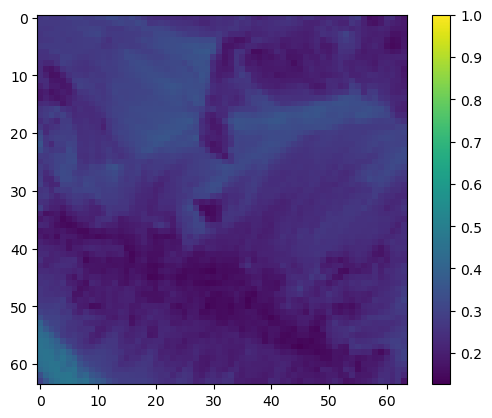

In [188]:

NIR_image = patch[3].unsqueeze(dim=0)#-> Remove first dim (channel) 
# add a new subplot iteratively

plt.imshow(NIR_image.permute(1, 2, 0),vmax=1)#, vmax=1.0)
plt.colorbar()
NIR_image.max(), patch[3].max()

In [62]:
import gc
del train_set
gc.collect()

5539

In [195]:
train_set.training_data

True

In [94]:
torch.cuda.is_available()

True

In [98]:
len(train_set.observations), len(train_set.centroids)

(17173, 17173)

In [196]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=64,  num_workers=8)

/srv/conda/envs/notebook/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Test BCELoss

In [197]:
batch_size = 8

loss_fn = torch.nn.BCELoss()

# outputs_before_sigmoid = torch.randn(batch_size, num_classes)
outputs_before_sigmoid = torch.randn(num_classes, dtype=float)
sigmoid_outputs = torch.sigmoid(outputs_before_sigmoid)
# target_classes = torch.randint(0, 2, (batch_size, num_classes),dtype=torch.float)  # randints in [0, 2).

# target_classes = torch.tensor([[1.0],[0.0]])
# sigmoid_outputs = torch.tensor([[0.8],[0.]])
print(len(sigmoid_outputs), len(target))
# print(type(sigmoid_outputs), type(torch.from_numpy(target)))
loss = loss_fn(sigmoid_outputs, target)
print(loss)

5079 5079
tensor(0.8050, dtype=torch.float64)


In [132]:
torch.from_numpy(target)

tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

# CNN

In [200]:
# model params
DROPOUT = 0.7
N_LABELS = num_classes
# N_INPUTS = patch.shape[0]
N_INPUTS = 27
N_LABELS

5079

In [201]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [202]:
%autoreload 2
from inception_env import InceptionEnv

In [203]:
# CONSTRUCT MODEL
model = InceptionEnv(dropout=DROPOUT, n_labels=N_LABELS, n_input=N_INPUTS)

#Load model on GPU
if torch.cuda.is_available():
    # check if GPU is available
    print("Training on GPU")
    model = model.to(device)
    model = torch.nn.DataParallel(model, device_ids=[i for i in range(torch.cuda.device_count())])
else:
    print("Training on CPU")


Training on GPU


In [204]:
from torchsummary import summary
summary(model, (N_INPUTS, 64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 80, 64, 64]          19,440
       BatchNorm2d-2           [-1, 80, 64, 64]             160
       BasicConv2d-3           [-1, 80, 64, 64]               0
            Conv2d-4           [-1, 80, 64, 64]          57,600
       BatchNorm2d-5           [-1, 80, 64, 64]             160
       BasicConv2d-6           [-1, 80, 64, 64]               0
            Conv2d-7          [-1, 100, 64, 64]          72,000
       BatchNorm2d-8          [-1, 100, 64, 64]             200
       BasicConv2d-9          [-1, 100, 64, 64]               0
           Conv2d-10          [-1, 124, 64, 64]          12,400
      BatchNorm2d-11          [-1, 124, 64, 64]             248
      BasicConv2d-12          [-1, 124, 64, 64]               0
           Conv2d-13          [-1, 192, 64, 64]         214,272
      BatchNorm2d-14          [-1, 192,

/srv/conda/envs/notebook/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### Debug: setting paths for imports

In [198]:
import sys
for path in sys.path:
    print(path)

/home/jovyan/sdm-geolifeCLEF/models
/home/jovyan/sdm-geolifeCLEF/raster
/home/jovyan/sdm-geolifeCLEF
/srv/conda/envs/notebook/lib/python39.zip
/srv/conda/envs/notebook/lib/python3.9
/srv/conda/envs/notebook/lib/python3.9/lib-dynload

/srv/conda/envs/notebook/lib/python3.9/site-packages


In [20]:
# sys.path.remove('/models')
# sys.path.remove('/raster')
# sys.path.remove('model/')
sys.path.remove('/models')
# sys.path.remove('/models')
# sys.path.remove('/raster')
